In [28]:
import wisardpkg as wp

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import librosa
import librosa.display

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [14]:
set_a = pd.read_csv("heart_sounds/set_a.csv")
set_a_timing = pd.read_csv("heart_sounds/set_a.csv")
set_b = pd.read_csv("heart_sounds/set_b.csv")

In [16]:
#merge both set-a and set-b
dataframes = [set_a, set_b]
train_ab = pd.concat(dataframes)
train_ab.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_b/Btraining_normal_Btraining_noisynormal_1...,normal,noisynormal
freq,656,1,351,120


In [17]:
#get all unique labels
nb_classes=train_ab.label.unique()

Min samples per category =  19
Max samples per category =  351


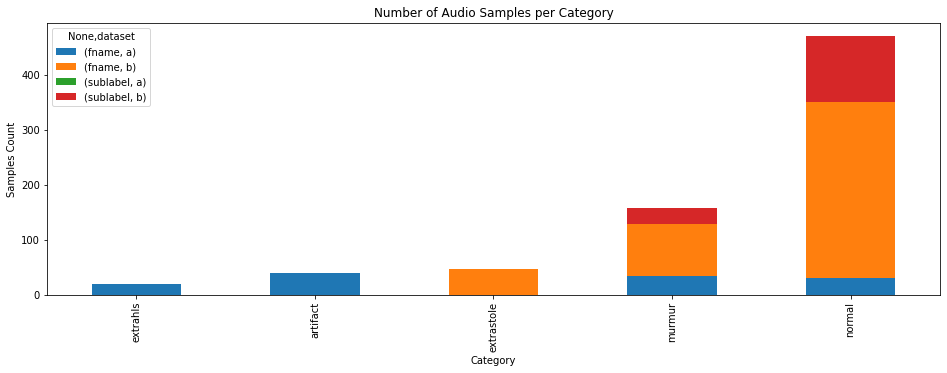

In [18]:
# visualize data distribution by category
category_group = train_ab.groupby(['label','dataset']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,5))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");

print('Min samples per category = ', min(train_ab.label.value_counts()))
print('Max samples per category = ', max(train_ab.label.value_counts()))

In [25]:
# Testing mfccs
y, sr = librosa.load('heart_sounds/set_a/normal__201108011118.wav')
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

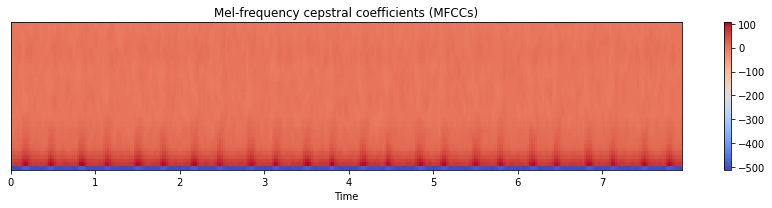

In [29]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()